In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt; plt.rc('font', size=16)
import pandas as pd
from pathlib import Path

In [2]:
# Define useful lookup variables

# Define the order of the taxa
order = ['B_cellulosilyticus_WH2', 
        'B_caccae', 
        'B_vulgatus', 
        'B_thetaiotaomicron', 
        'B_ovatus', 
        'R_obeum', 
        'B_uniformis', 
        'P_distasonis', 
        'C_scindens', 
        'C_aerofaciens', 
        'C_spiroforme', 
        # 'D_longicatena'
        ]

# Define the pretty names of the taxa
pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$ WH2',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                # 'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'
                }

# Define the order of the taxa using the pretty names
pretty_order = [pretty_names_dir[organism] for organism in order]

# Define the colors of the taxa
cols = ['#016bff',
        '#b91f1c',
        '#308937',
        '#ff8137',
        '#6f4fc7',
        '#d4b300',
        '#893a2b',
        '#ff6c79',
        '#16c4ff',
        '#766f41',
        '#00c800',
        # '#af3261'
        ]

# Define the mapping between taxa and colors
taxa_color_mapping = {order: cols[i] for i, order in enumerate(order)}

In [3]:
# Define functions

# Define a function to parse the dataframe
def parse_df(df, ordering):
    # Get the mean abundance per species
    df_mean = df.copy()
    df_mean = df_mean.groupby(['name', 'Day']).mean().reset_index()
    df_mean.set_index('name', inplace=True)
    df_mean.drop(columns=['Mouse'], inplace=True)
    df_mean = df_mean.pivot_table(index='Day', columns=df_mean.index, values='Absolute_abundance')
    df_mean.columns.name = None
    df_mean = df_mean.loc[:,ordering]
    # Get the standard deviation of the abundance per species
    df_std = df.copy()
    df_std = df.groupby(['name', 'Day']).std().reset_index()
    df_std.set_index('name', inplace=True)
    df_std.drop(columns=['Mouse'], inplace=True)
    df_std = df_std.pivot_table(index='Day', columns=df_std.index, values='Absolute_abundance')
    df_std.columns.name = None
    df_std = df_std.loc[:,ordering]
    return df_mean, df_std

# Define a function to plot the abundance using a bar plot
def plot_abundance_bar(df, dataset='LF0', ordering=order, complete_days=False, logy=False, pretty_names=True, std=True, legend=True, figsize=(10, 7), ax=None, save_f=None):
    # Pretty names
    if pretty_names:
        df['name'] = df['name'].replace(pretty_names_dir)
        ordering = pretty_order
    df_mean, df_std = parse_df(df, ordering=ordering)
    if complete_days:
        for day in np.arange(0, 40+1):
            if day not in df_mean.index:
                df_mean.loc[day] = 0
                df_std.loc[day] = 0
        df_mean.sort_index(inplace=True)
        df_std.sort_index(inplace=True)
    # If std is False, set it to None
    if not std:
        df_std = None
    # Get the index of the days to fill
    if dataset == 'LF0':
        fill_indx = [plot_indx for plot_indx, df_indx in enumerate(df_mean.index) if df_indx in np.arange(13, 27+1)]
    elif dataset == 'HF0':
        fill_indx0 = [plot_indx for plot_indx, df_indx in enumerate(df_mean.index) if df_indx in np.arange(0, 13+1)]
        fill_indx1 = [plot_indx for plot_indx, df_indx in enumerate(df_mean.index) if df_indx in np.arange(27, 40+1)]
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    df_mean.plot.bar(stacked=True, 
        figsize=figsize, 
        width=0.9, 
        color=cols, 
        rot=0, 
        edgecolor='white', 
        linewidth=0.3,
        ax=ax,
        yerr=df_std,
        error_kw={'elinewidth': 1, 'capsize': 3, 'capthick': 1},
        legend=legend)
    if dataset == 'LF0':
        ax.fill_between(x=fill_indx, y1=0, y2=1e10, color='grey', alpha=0.2)
    elif dataset == 'HF0':
        ax.fill_between(x=fill_indx0, y1=0, y2=1e10, color='grey', alpha=0.2)
        ax.fill_between(x=fill_indx1, y1=0, y2=1e10, color='grey', alpha=0.2)
    if legend:
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax.set_xlabel('Day')
    if complete_days:
        ax.set_xticks(np.arange(0, 40+1, 2))
    if logy:
        ax.set_yscale('log')
        ax.set_ylabel('Log$_{10}$ absolute abundance')
        ax.set_ylim(1, 1e9)
    else:
        ax.set_ylabel('Absolute abundance')
        ax.set_ylim(1e2, 7.3e8)
    if save_f is not None:
        fig.savefig(f'{save_f}', bbox_inches='tight')
    return fig, ax

# Define a function to plot the abundance using a line plot
def plot_abundance_line(df, dataset='LF0', ordering=order, logy=False, pretty_names=True, points=False, std=True, legend=True, figsize=(10, 7), ax=None, save_f=None):
    # Pretty names
    if pretty_names:
        df['name'] = df['name'].replace(pretty_names_dir)
        ordering = pretty_order
    df_mean, df_std = parse_df(df, ordering=ordering)
    # If std is False, set it to None
    if not std:
        df_std = None
    # Get the index of the days to fill
    if dataset == 'LF0':
        fill_indx = [13, 27]
    elif dataset == 'HF0':
        fill_indx0 = [0, 13]
        fill_indx1 = [27, 40]
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    df_mean.plot.line(figsize=figsize, 
        color=cols, 
        rot=0, 
        ax=ax,
        legend=legend)
    if points:
        col = 0
        for i in df_mean.mean(axis=0).sort_values(ascending=False).index:
            x_df = {}
            y_df = {}
            x_df[i] = df[df.name == i].Day.values
            y_df[i] = df[df.name == i].Absolute_abundance.values
            ax.scatter(x_df[i], y_df[i], s=25, color=cols[col])
            col += 1
    if std:
        col = 0
        for i in df_mean.mean(axis=0).sort_values(ascending=False).index:
            x_df_mean = {}
            y_df_mean = {}
            y_df_std = {}
            x_df_mean[i] = df_mean.index.values
            y_df_mean[i] = df_mean.loc[:,i].values
            y_df_std[i] = df_std.loc[:,i].values
            plt.errorbar(x_df_mean[i], y_df_mean[i], y_df_std[i], color=cols[col], linestyle='None', elinewidth=2, capsize=5,
                         fmt='s', markersize=5, markeredgewidth=1)
            col += 1
    if dataset == 'LF0':
        ax.fill_between(x=fill_indx, y1=0, y2=1e10, color='grey', alpha=0.2)
    elif dataset == 'HF0':
        ax.fill_between(x=fill_indx0, y1=0, y2=1e10, color='grey', alpha=0.2)
        ax.fill_between(x=fill_indx1, y1=0, y2=1e10, color='grey', alpha=0.2)
    if legend:
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax.set_xlabel('Day')
    if logy:
        ax.set_yscale('log')
        ax.set_ylabel('Log$_{10}$ Absolute abundance')
        ax.set_ylim(1e4, 1e9)
    else:
        ax.set_ylabel('Absolute abundance')
        ax.set_ylim(1e4, 3.7e8)
    ax.set_xlim([-0.1, 40.1])
    if save_f is not None:
        fig.savefig(f'{save_f}', bbox_inches='tight')
    return fig, ax

# Define a function to plot the abundance using an area plot
def plot_abundance_area(df, dataset='LF0', ordering=order, logy=False, pretty_names=True, std=True, legend=True, figsize=(10, 7), ax=None, save_f=None):
    # Pretty names
    if pretty_names:
        df['name'] = df['name'].replace(pretty_names_dir)
        ordering = pretty_order
    df_mean, df_std = parse_df(df, ordering=ordering)
    if not std:
        df_std = None
    # Get the index of the days to fill
    if dataset == 'LF0':
        fill_indx = [13, 27]
    elif dataset == 'HF0':
        fill_indx0 = [0, 13]
        fill_indx1 = [27, 40]
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    df_mean.plot.area(stacked=True, 
        figsize=figsize, 
        color=cols, 
        rot=0, 
        linewidth=0.3,
        ax=ax,
        legend=legend)
    if std:
        df_mean_stacked = []
        for i in range(len(df_mean.columns)):
            df_mean_stacked.append(plt.gca().get_lines()[i].get_ydata())
        df_mean_stacked = np.array(df_mean_stacked)
        df_mean_stacked = df_mean_stacked.T
        df_mean_stacked = pd.DataFrame(df_mean_stacked, columns=df_mean.columns, index=df_mean.index)
        for i in df_mean.mean(axis=0).sort_values(ascending=False).index:
            x_df_mean = {}
            y_df_mean = {}
            y_df_std = {}
            x_df_mean[i] = df_mean_stacked.index.values
            y_df_mean[i] = df_mean_stacked.loc[:,i].values
            y_df_std[i] = df_std.loc[:,i].values
            plt.errorbar(x_df_mean[i], y_df_mean[i], y_df_std[i], color='k', linestyle='None', elinewidth=1, capsize=2)
    if dataset == 'LF0':
        ax.fill_between(x=fill_indx, y1=0, y2=1e10, color='grey', alpha=0.2)
    elif dataset == 'HF0':
        ax.fill_between(x=fill_indx0, y1=0, y2=1e10, color='grey', alpha=0.2)
        ax.fill_between(x=fill_indx1, y1=0, y2=1e10, color='grey', alpha=0.2)
    if legend:
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax.set_xlabel('Day')
    if logy:
        ax.set_yscale('log')
        ax.set_ylabel('Log$_{10}$ absolute abundance')
        ax.set_ylim(1e2, 1e9)
    else:
        ax.set_ylabel('Absolute abundance')
        ax.set_ylim(1e4, 7.3e8)
    ax.set_xlim([-0.1, 40.1])
    if save_f is not None:
        fig.savefig(f'{save_f}', bbox_inches='tight')
    return fig, ax

In [4]:
# Define a function to parse the reads dataframe
def parse_reads(reads, ordering=order):
    # Get the mean relative abundances per species per day
    reads_df = reads.copy()
    reads_df.set_index('name', inplace=True)
    reads_df = reads_df.T
    reads_df.columns.name = None
    reads_df.index.name = 'Mouse-Day'
    reads_df = reads_df.divide(reads_df.sum(axis=1), axis=0)
    reads_df.reset_index(inplace=True)
    reads_df[['Mouse', 'Day']] = reads_df['Mouse-Day'].str.split('-', expand=True)
    reads_df.drop(['Mouse-Day', 'Mouse'], axis=1, inplace=True)
    reads_df['Day'] = reads_df['Day'].astype(int)
    # Get the mean relative abundances per species per day
    reads_mean = reads_df.groupby('Day').mean().copy()
    reads_mean = reads_mean.loc[:,ordering]
    # Get the std relative abundances per species per day
    reads_std = reads_df.groupby('Day').std().copy()
    reads_std = reads_std.loc[:,ordering].copy()
    return reads_mean, reads_std

# Define a function to parse the dna molecules dataframe
def parse_dna_molecules(dna_molecules):
    # Get the mean absolute abundances per day
    dna_molecules_df = dna_molecules.copy()
    dna_molecules_df.drop(['measurement2', 'measurement3'], axis=1, inplace=True)
    dna_molecules_df[['Mouse', 'Day']] = dna_molecules_df['sampleID'].str.split('-', expand=True)
    dna_molecules_df.drop(['sampleID', 'Mouse'], axis=1, inplace=True)
    dna_molecules_df['Day'] = dna_molecules_df['Day'].astype(int)
    # Get the mean absolute abundances per day
    dna_molecules_mean = dna_molecules_df.groupby('Day').mean().copy()
    # Get the std absolute abundances per day
    dna_molecules_std = dna_molecules_df.groupby('Day').std().copy()
    return dna_molecules_df, dna_molecules_mean, dna_molecules_std

# Define a function to plot the relative abundance using a bar plot
def plot_relative_abundance(reads, dataset='LF0', complete_days=False, pretty_names=True, std=True, legend=True, figsize=(10, 7), ax=None, save_f=None):
    # Pretty names
    reads = reads.copy()
    if pretty_names:
        reads['name'] = reads['name'].replace(pretty_names_dir)
        ordering = pretty_order
    reads_mean, reads_std = parse_reads(reads, ordering=ordering)
    if complete_days:
        for day in np.arange(0, 40+1):
            if day not in reads_mean.index:
                reads_mean.loc[day] = 0
                reads_std.loc[day] = 0
        reads_mean.sort_index(inplace=True)
        reads_std.sort_index(inplace=True)
    # If std is False, set it to None
    if not std:
        reads_std = None
    # Get the index of the days to fill
    if dataset == 'LF0':
        fill_indx = [plot_indx for plot_indx, df_indx in enumerate(reads_mean.index) if df_indx in np.arange(13, 27+1)]
    elif dataset == 'HF0':
        fill_indx0 = [plot_indx for plot_indx, df_indx in enumerate(reads_mean.index) if df_indx in np.arange(0, 13+1)]
        fill_indx1 = [plot_indx for plot_indx, df_indx in enumerate(reads_mean.index) if df_indx in np.arange(27, 40+1)]
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    reads_mean.plot.bar(stacked=True, 
        figsize=figsize, 
        width=1, 
        color=cols, 
        rot=0, 
        edgecolor='white', 
        linewidth=0.3,
        ax=ax,
        ylim=(0, 1.01),
        yerr=reads_std,
        error_kw={'elinewidth': 1, 'capsize': 3, 'capthick': 1},
        legend=legend)
    if dataset == 'LF0':
        ax.fill_between(x=fill_indx, y1=0, y2=1.01, color='grey', alpha=0.5, edgecolor='black', linewidth=2, linestyle='--')
    elif dataset == 'HF0':
        ax.fill_between(x=fill_indx0, y1=0, y2=1.01, color='grey', alpha=0.5, edgecolor='black', linewidth=2, linestyle='--')
        ax.fill_between(x=fill_indx1, y1=0, y2=1.01, color='grey', alpha=0.5, edgecolor='black', linewidth=2, linestyle='--')
    if legend:
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax.set_xlabel('Day')
    if complete_days:
        ax.set_xticks(np.arange(0, 40+1, 2))
    ax.set_ylabel('Relative abundance')
    if save_f is not None:
        fig.savefig(f'{save_f}', bbox_inches='tight')
    return fig, ax

# Define a function to plot the absolute abundance using a line plot
def plot_absolute_dna(dna_molecules, dataset='LF0', logy=False, points=True, std=True, figsize=(10, 7), ax=None, save_f=None):
    dna_molecules_df, dna_molecules_mean, dna_molecules_std = parse_dna_molecules(dna_molecules)
    # If std is False, set it to None
    if not std:
        dna_molecules_std = None
    # Get the index of the days to fill
    if dataset == 'LF0':
        fill_indx = [13, 27]
    elif dataset == 'HF0':
        fill_indx0 = [0, 13]
        fill_indx1 = [27, 40]
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    dna_molecules_mean.plot.line(figsize=figsize, 
        color='k', 
        rot=0, 
        ax=ax,
        legend=False)
    if points:
        dna_molecules_df.plot.scatter(x='Day', y='measurement1', 
            figsize=figsize, 
            color='k', 
            rot=0, 
            ax=ax)
    if std is not None:
        ax.errorbar(x=dna_molecules_mean.index, y=dna_molecules_mean['measurement1'], yerr=dna_molecules_std['measurement1'], color='grey', alpha=0.8, elinewidth=1, capsize=2)
    if dataset == 'LF0':
        ax.fill_between(x=fill_indx, y1=0, y2=1e11, color='grey', alpha=0.4)
    elif dataset == 'HF0':
        ax.fill_between(x=fill_indx0, y1=0, y2=1e11, color='grey', alpha=0.4)
        ax.fill_between(x=fill_indx1, y1=0, y2=1e11, color='grey', alpha=0.4)
    ax.set_xlabel('Day')
    if logy:
        ax.set_yscale('log')
        ax.set_ylabel('Log$_{10}$ CFU/g feces')
        ax.set_ylim(3e7, 2e9)
    else:
        ax.set_ylabel('CFU/g feces')
        ax.set_ylim(0, 1e9)
    ax.set_xlim([-0.5, 40.5])
    if save_f is not None:
        fig.savefig(f'{save_f}', bbox_inches='tight')
    return fig, ax

In [5]:
# Datasets
dataset = ['LF0', 'HF0']
# Define the input directory
input_dir = Path(f'mcnulty-datasets/{dataset[0]}') , Path(f'mcnulty-datasets/{dataset[1]}')
# Load the absolute abundance tables
LF0 = pd.read_table(input_dir[0] / 'abs_abundances_per_species.tsv')
HF0 = pd.read_table(input_dir[1] / 'abs_abundances_per_species.tsv')
# Load the reads tables
lf0_reads = pd.read_table(input_dir[0] / 'reads.tsv')
hf0_reads = pd.read_table(input_dir[1] / 'reads.tsv')
# Load the dna molecules tables
lf0_dnamolcs = pd.read_table(input_dir[0] / 'dna_molecules.tsv')
hf0_dnamolcs = pd.read_table(input_dir[1] / 'dna_molecules.tsv')

# LF/HPP ==> HF/HS ==> LF/HPP (LF0)

### Relative abundance per species

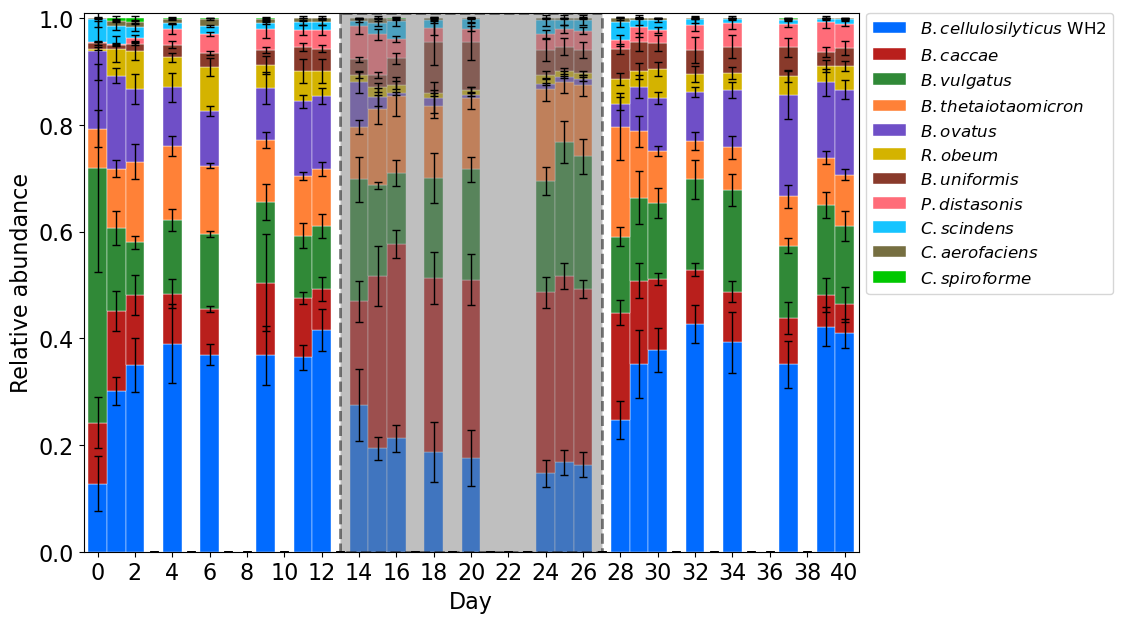

In [6]:
plot_relative_abundance(lf0_reads, complete_days=True)
plt.savefig('mcnulty-results/abundances/lf0_rel_bar_true.svg', bbox_inches='tight')
plt.show()

### Absolute abundance of the community

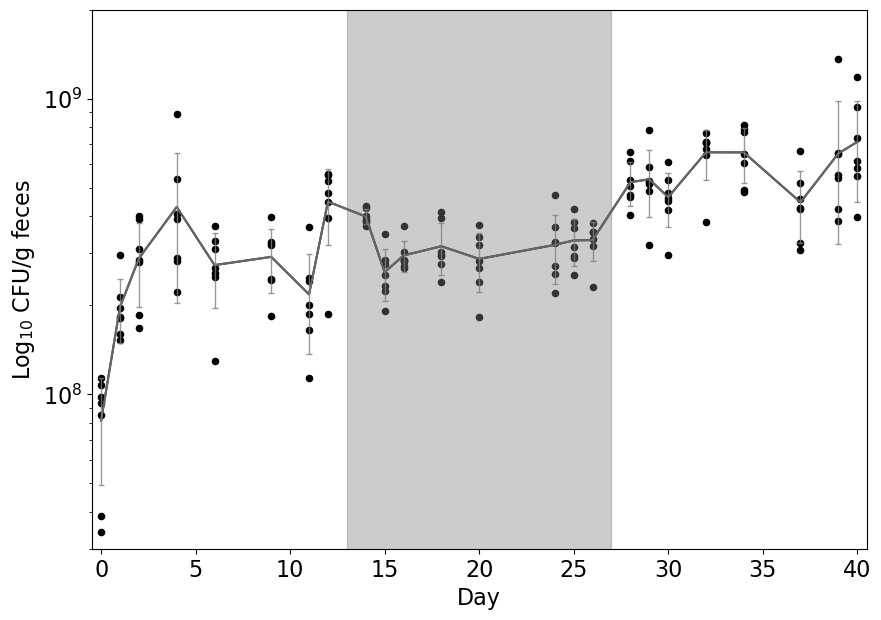

In [7]:
plot_absolute_dna(lf0_dnamolcs, logy=True)
plt.savefig('mcnulty-results/abundances/lf0_dna_abun.svg', bbox_inches='tight')
plt.show()

### Absolute abundace per species

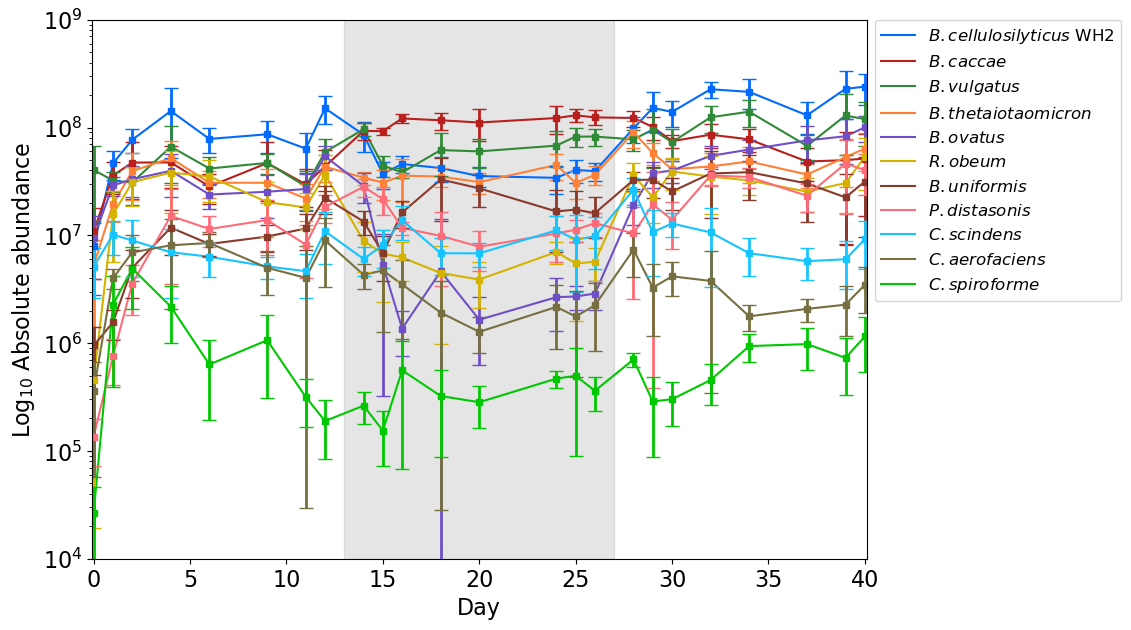

In [8]:
plot_abundance_line(LF0, logy=True)
plt.savefig('mcnulty-results/abundances/lf0_abs.svg', bbox_inches='tight')
plt.show()

# HF/HS ==> LF/HPP ==> HF/HS (HF0)

### Relative abundance per species

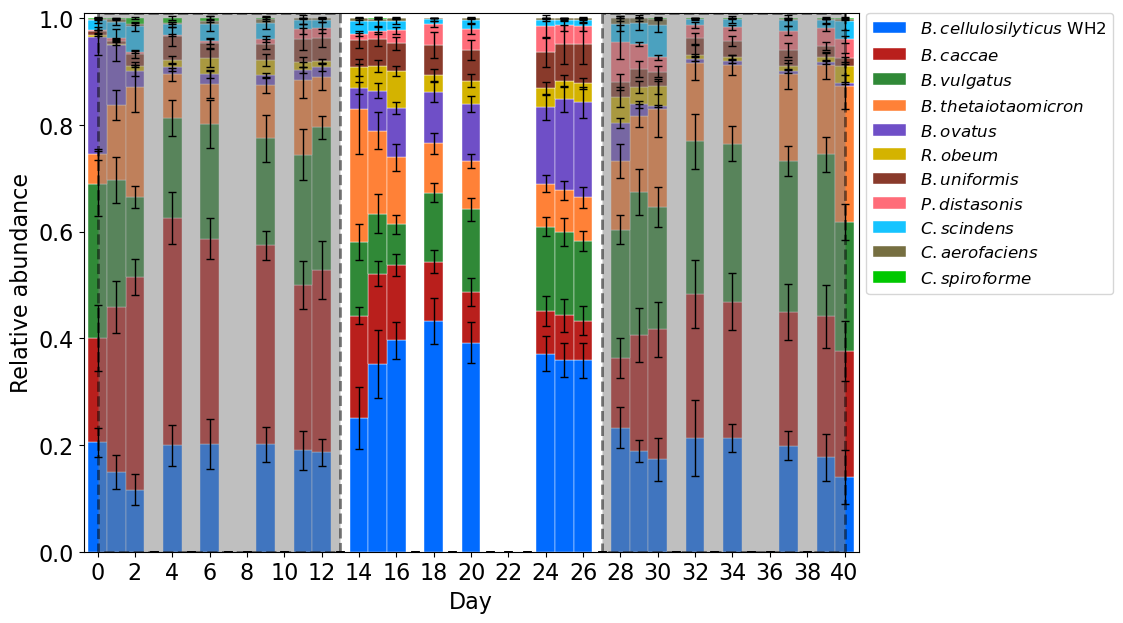

In [9]:
plot_relative_abundance(hf0_reads, dataset='HF0', complete_days=True)
plt.savefig('mcnulty-results/abundances/hf0_rel_bar_true.svg', bbox_inches='tight')
plt.show()

### Absolute abundance of the community

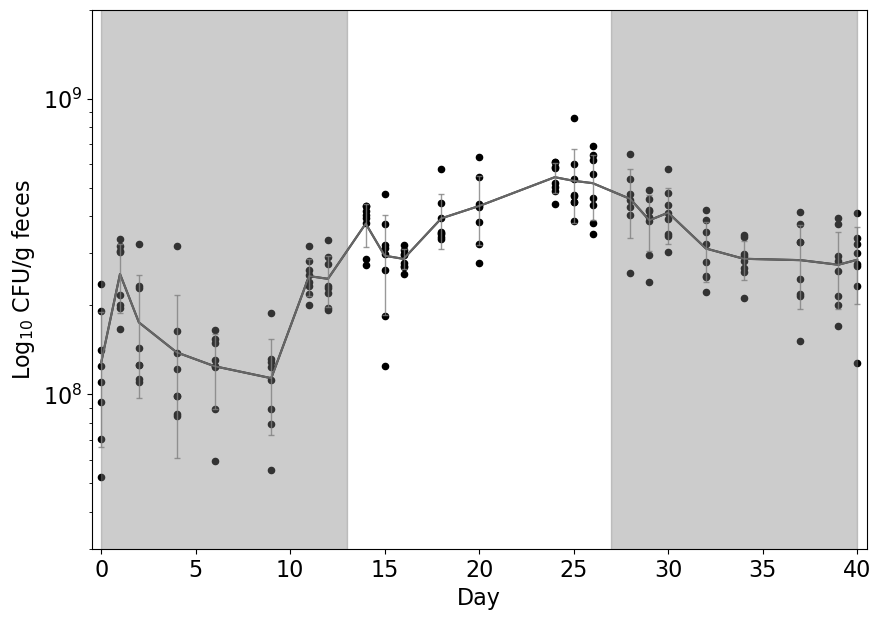

In [10]:
plot_absolute_dna(hf0_dnamolcs, dataset='HF0', logy=True)
plt.savefig('mcnulty-results/abundances/hf0_dna_abun.svg', bbox_inches='tight')
plt.show()

### Absolute abundance of the community

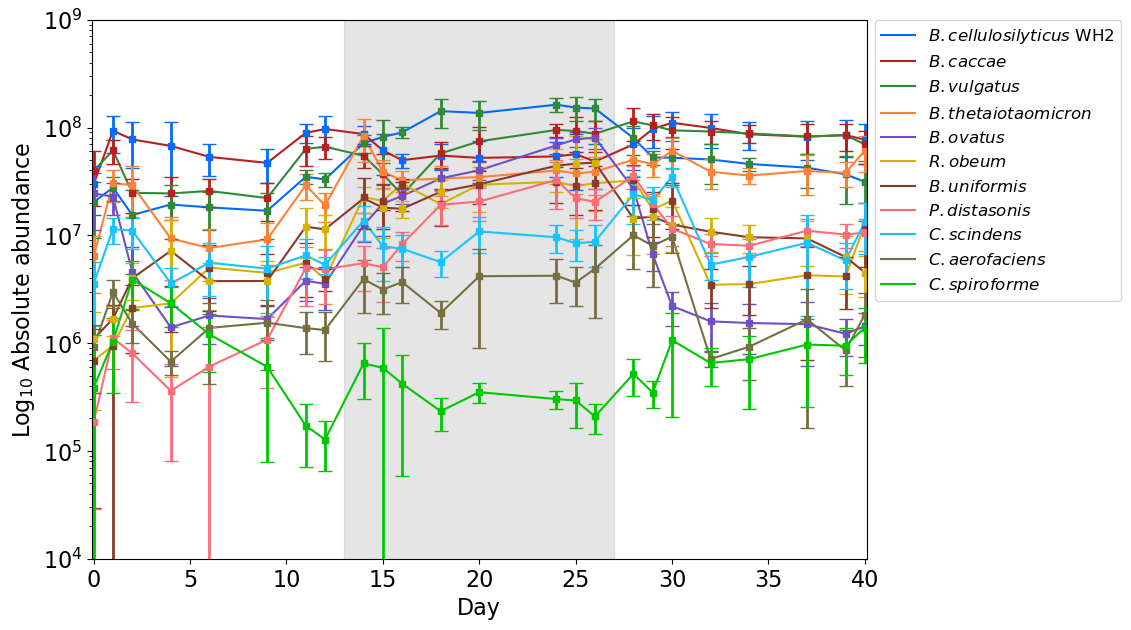

In [11]:
plot_abundance_line(HF0, logy=True)
plt.savefig('mcnulty-results/abundances/hf0_abs.svg', bbox_inches='tight')
plt.show()

# Analysis

* Biomass yield is in general higher in LF/HPP than in HF/HS in both LF0 and HF0.
* _B. cellulosilyticus_ dominates the community in LF/HPP in both LF0 and HF0, while _B. caccae_ dominates the community in HF/HS in both LF0 and HF0.
    * Although _B. caccae_ is the dominant species in HF/HS, its biomass yield is lower than that of _B. cellulosilyticus_ in LF/HPP.